Text normalization is all about converting text from written expression into appropriate "spoken" forms. For example, 11:36 would convert to "eleven thiry-six" while $5.18 would become "five dollars, eighteen cents." The purpose of this data set is to automate the process of developing text normalization grammars using various machine learning models. To get started, we will perform a simple EDA. 

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

How many training samples do we have and how many attributes are given per sample?

In [4]:
train = pd.read_csv('/Users/anthonybransford/Desktop/text-normalization-challenge-english-language/en_train.csv.zip')
train.shape

(9918441, 5)

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9918441 entries, 0 to 9918440
Data columns (total 5 columns):
sentence_id    int64
token_id       int64
class          object
before         object
after          object
dtypes: int64(2), object(3)
memory usage: 378.4+ MB


In [13]:
train.head(10)

,sentence_id,token_id,class,before,after
0,0,0,PLAIN,Brillantaisia,Brillantaisia
1,0,1,PLAIN,is,is
2,0,2,PLAIN,a,a
3,0,3,PLAIN,genus,genus
4,0,4,PLAIN,of,of
5,0,5,PLAIN,plant,plant
6,0,6,PLAIN,in,in
7,0,7,PLAIN,family,family
8,0,8,PLAIN,Acanthaceae,Acanthaceae
9,0,9,PUNCT,.,.


We see that there is an id associated with each sentence and each token (the first two features). We also see that with each token there is an associated class type. The goal of the data set is to take the tokens found in the "before" feature and transform them into the tokens found in the "after" column.  

How many test samples do we have?

In [15]:
test = pd.read_csv('/Users/anthonybransford/Desktop/text-normalization-challenge-english-language/en_test.csv.zip')
test.shape

(1088564, 3)

In [16]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1088564 entries, 0 to 1088563
Data columns (total 3 columns):
sentence_id    1088564 non-null int64
token_id       1088564 non-null int64
before         1088551 non-null object
dtypes: int64(2), object(1)
memory usage: 24.9+ MB


In [17]:
test.head()

,sentence_id,token_id,before
0,0,0,Another
1,0,1,religious
2,0,2,family
3,0,3,is
4,0,4,of


We see that the test set doesn't have the "class" column.

How many sentences total do both our train and test sets have?

In [18]:
num_train_sentences = len(train.sentence_id.unique())
num_train_sentences

748066

In [26]:
num_test_sentences = len(test.sentence_id.unique())
num_test_sentences

70000

In [28]:
num_test_sentences / (num_train_sentences + num_test_sentences)
#about 9% test size

0.0855676681343559

How long are these sentences?

In [20]:
train_sentences = train.groupby("sentence_id")["sentence_id"].count()
train_sentences.describe()

count    748066.000000
mean         13.258778
std           6.071624
min           2.000000
25%           8.000000
50%          13.000000
75%          18.000000
max         256.000000
Name: sentence_id, dtype: float64

We see that most of the sentences are between 8 and 18 tokens long. Let's take a second to visualize this distribution. 

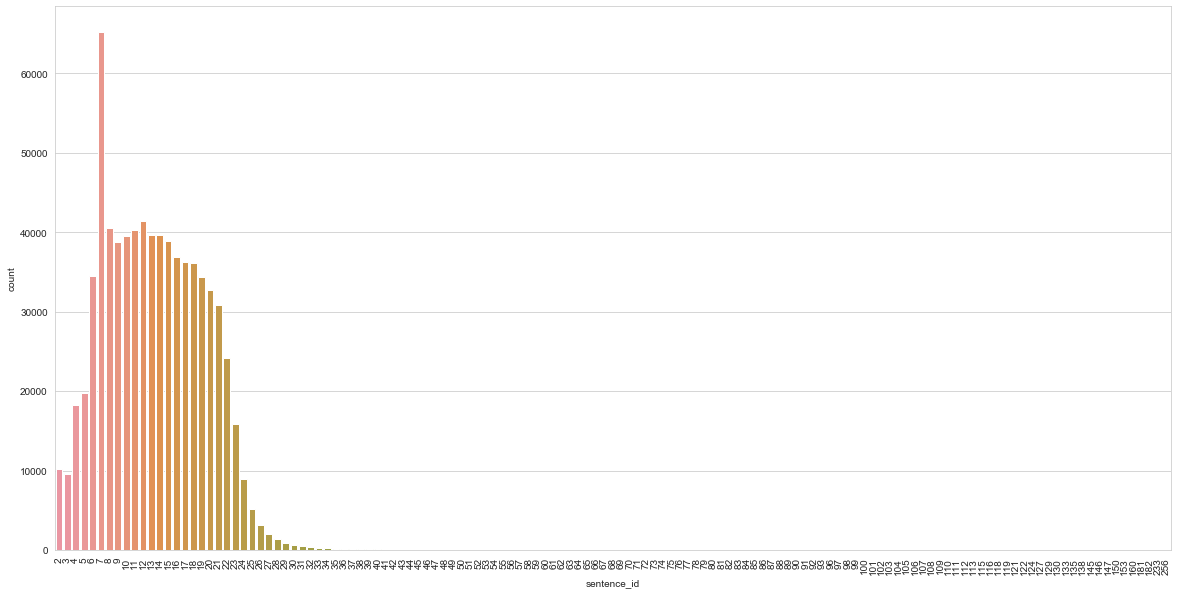

In [25]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.set_style("whitegrid")
count_length_fig = sns.countplot(train_sentences, ax=ax)
for item in count_length_fig.get_xticklabels():
    item.set_rotation(90)

Take note of the massive peak for sentences that are 7 tokens long. We might want to revisit this later and dive a little deeper, but for now, let's continue on with the length of our sentences.

In [22]:
test_sentences = test.groupby("sentence_id")["sentence_id"].count()
test_sentences.describe()

count    70000.000000
mean        15.550914
std          5.763962
min          2.000000
25%         11.000000
50%         16.000000
75%         20.000000
max        249.000000
Name: sentence_id, dtype: float64

In the test set, most of the sentences are between 11 and 20 tokens long.

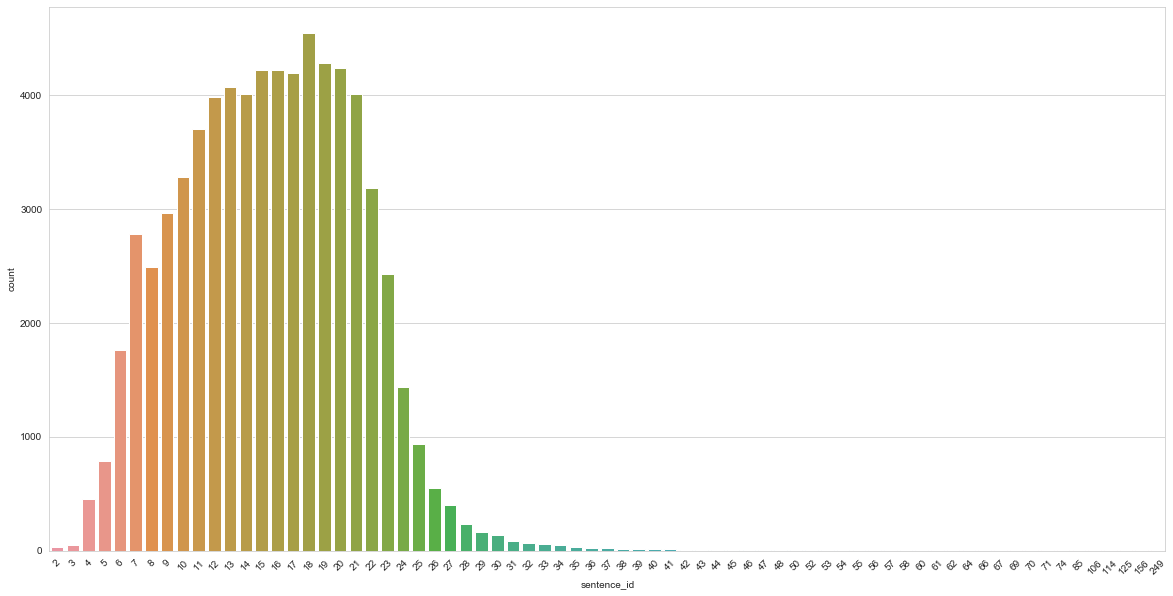

In [23]:
fig, ax = plt.subplots(1,1, figsize=(20,10))
sns.set_style("whitegrid")
count_length_fig = sns.countplot(test_sentences, ax=ax)
for item in count_length_fig.get_xticklabels():
    item.set_rotation(45)

The mean and quantiles in the test set are shifted slightly towards higher values when compared to the train set. I believe this is most likely due to the low test size of about 9% which we discovered earlier. 

Let's take a look at some short, medium and long sentences.

In [29]:
max_id = train_sentences[train_sentences == train_sentences.max()].index.values
max_id

array([520453])

In [30]:
long_example = train[train.sentence_id==max_id[0]].before.values.tolist()
long_example = ' '.join(long_example)
long_example

"R . Naroll , V.L. Bullough & F. Naroll , Military Deterrence in History : A Pilot Cross Historical Survey , SUNY Press , 1974 H . Temporini & W. Haase , Aufstieg und Niedergang der romischen Welt : Geschichte und Kultur Roms im spiegel der neueren Forschung , Walter de GruyterE . Yarshater , The Cambridge History of Iran , Cambridge University Press , 1983 R . Syme & A.R. Birley , Anatolica : studies in Strabo , Oxford University Press , 1995 W.G. Sayles , Ancient Coin Collecting IV : Roman Provincial Coins ( Google eBook ) , F +W Media , Inc , 1998 P.M. Swan , The Augustan Succession : An Historical Commentary on Cassius Dio's Roman History , Books 55 - 56 ( 9 B.C. - A.D. 14 ) ( Google eBook ) , Oxford University Press , 2004 R.G. Hovannisian , The Armenian People from Ancient to Modern Times , Volume 1 : The Dynastic Periods : From Antiquity to the Fourteenth Century , Palgrave Macmillan , 2004 V.M. Kurkjian , A History of Armenia , Indo European Publishing , 2008 M.A. Ehrlich , Enc

This appears to be a literature reference.

In [32]:
min_id = train_sentences[train_sentences == train_sentences.min()].index.values
min_id

array([    41,    109,    144, ..., 747154, 747855, 747920])

In [33]:
for n in range(5):
    small_example = train[train.sentence_id==min_id[n]].before.values.tolist()
    small_example = ' '.join(small_example)
    print(small_example)

August 16, 2005 .
June 10, 2012 .
16 December 2006 .
March 30, 2011 .
17 July 2013 .


We see that some of the shorter sentences are dates.

In [34]:
median_id = train_sentences[train_sentences == train_sentences.median()].index.values
median_id

array([    31,     56,     85, ..., 747973, 748050, 748057])

In [35]:
for n in range(5):
    median_example = train[train.sentence_id==median_id[n]].before.values.tolist()
    median_example = ' '.join(median_example)
    print(median_example)

Herry was born in Banda Aceh , Aceh from a Sundanese descendant .
It is led by the incumbent mayor of Lviv , Andriy Sadovyi .
The cemetery of Meir II : The tomb of Pepyankh the Black .
This race was a support event of the 1987 Australian Grand Prix .
The film derives its name from 68 pages of a counselors diary .


Now that we've taken some time to explore our sentences as a whole, let's shift over to our tokens. How many unique tokens do we have?

In [36]:
len(train.token_id.unique())

256

After reading the explanations for the data in detail: Each token within a sentence has a token_id. Consequently the longest sentence has token ids ranging from 0 to 255 (inclusive), and one of the smallest from 0 to 1. How many token classes do we have? And how many counts per class?

In [37]:
len(train["class"].unique())
#16 different token classes

16

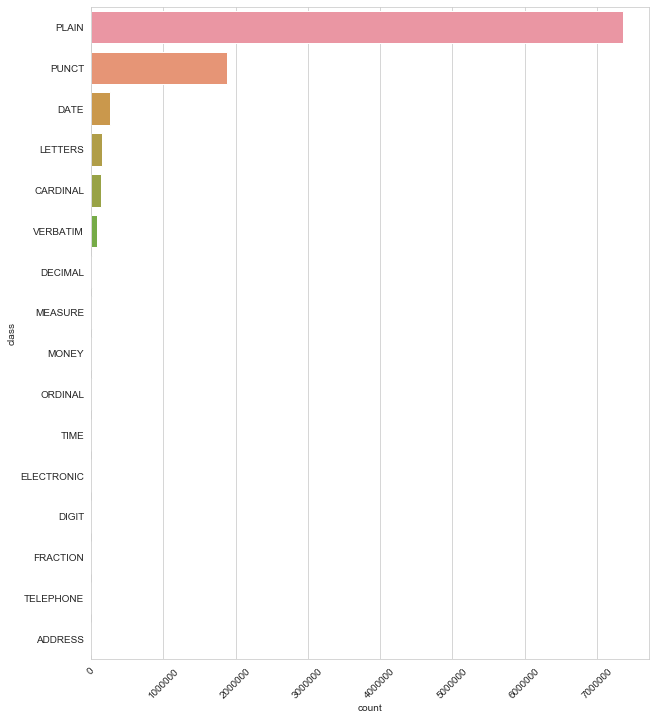

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,12))
#sns.set_style("whitegrid")
count_classes_fig = sns.countplot(y="class", data=train, ax=ax)
for item in count_classes_fig.get_xticklabels():
    item.set_rotation(45)
#number per class

In [39]:
train.groupby("class")["class"].count()

class
ADDRESS           522
CARDINAL       133744
DATE           258348
DECIMAL          9821
DIGIT            5442
ELECTRONIC       5162
FRACTION         1196
LETTERS        152795
MEASURE         14783
MONEY            6128
ORDINAL         12703
PLAIN         7353693
PUNCT         1880507
TELEPHONE        4024
TIME             1465
VERBATIM        78108
Name: class, dtype: int64

Most are plain but there are also some weird classes such as electronic and verbatim. What's meant by these?

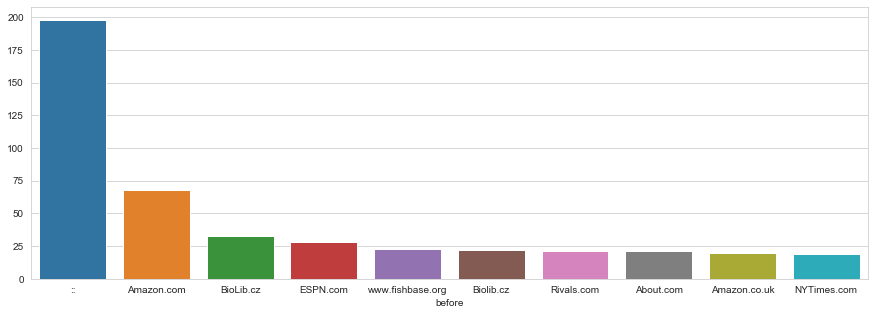

In [40]:
most_electronic_cases = train[train["class"]=='ELECTRONIC'].groupby("before")["before"].count(
).sort_values(ascending=False).head(10)
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x=most_electronic_cases.index, y=most_electronic_cases.values)
#electronic class examples

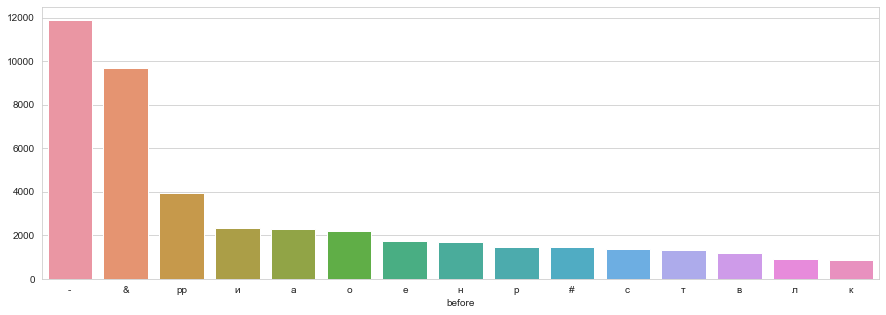

In [41]:
most_verbatim_cases = train[train["class"]=='VERBATIM'].groupby("before")["before"].count(
).sort_values(ascending=False).head(15)
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x=most_verbatim_cases.index, y=most_verbatim_cases.values)
#verbatim class examples

Now, how many unique "before" words do we have and what do the most common look like?

In [42]:
len(train.before.unique())

486443

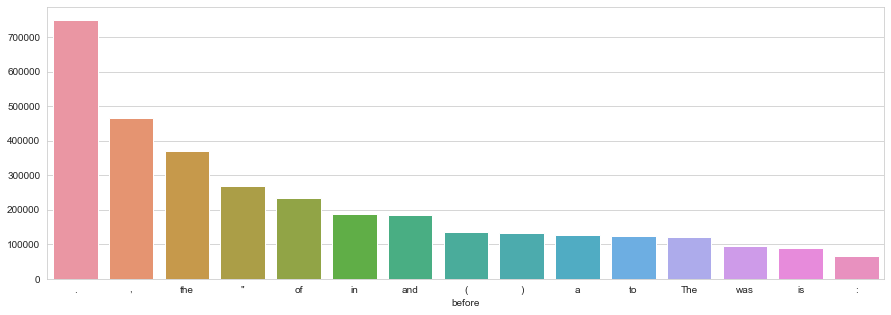

In [43]:
train_word_counts = train.groupby("before")["before"].count().sort_values(ascending=False).head(15)
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x=train_word_counts.index, y=train_word_counts.values)

In [44]:
len(test.before.unique())

116854

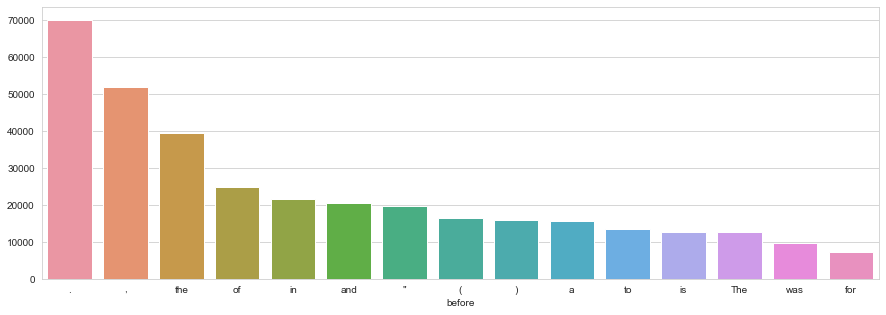

In [45]:
test_word_counts = test.groupby("before")["before"].count().sort_values(ascending=False).head(15)
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x=test_word_counts.index, y=test_word_counts.values)

Let's take a look at the pattern of change for "before" words once normalization has occurred in the train set.

In [46]:
train["change"] = 0
train.loc[train.before!=train.after, "change"] = 1
train["change"].value_counts()
#659,862 words changed

0    9258579
1     659862
Name: change, dtype: int64

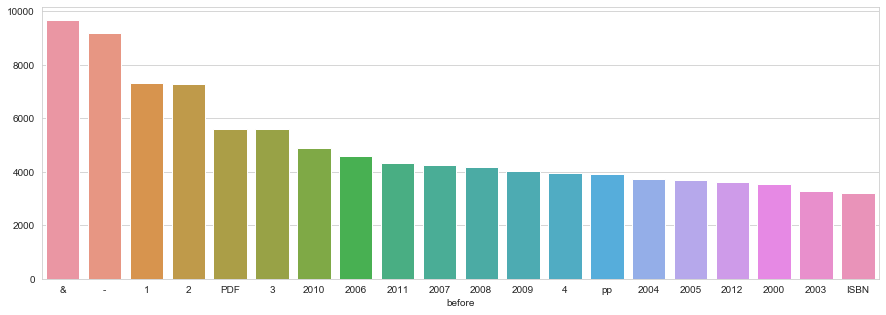

In [47]:
most_changed_words = train[train.change==1].groupby("before")["before"].count(
).sort_values(ascending=False).head(20)
fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.barplot(x=most_changed_words.index, y=most_changed_words.values)
#the two most changed words were an ampersand and a hyphen. The next two most changed were the numbers 1 & 2.
#finally, the fifth most changed was "PDF"

Which classes have the most changed words?

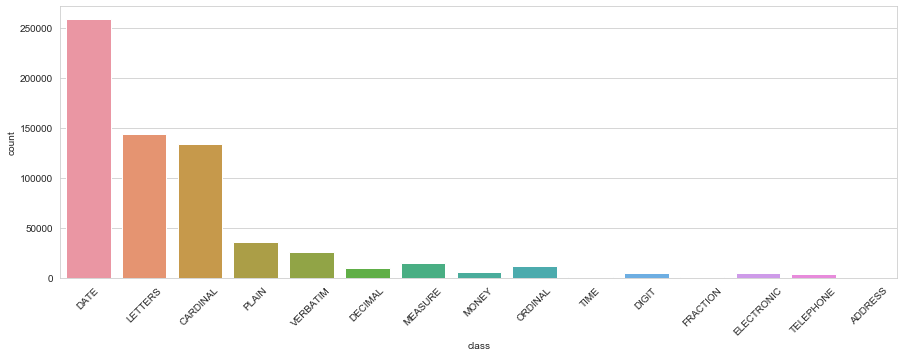

In [48]:
fig, ax = plt.subplots(1,1,figsize=(15,5))
changes_classes_fig = sns.countplot(x="class", data=train[train.change==1])
for item in changes_classes_fig.get_xticklabels():
    item.set_rotation(45)

I found it a bit strange that we have a digit, decimal, date, cardinal, ordinal, fraction class etc.. Are the tokens in these classes really all that different or can we find the same token, for example, in date AND digit? If so, why are they classified like this? Does this depend on the sentence content?

In [49]:
unique_digits = set(train[train["class"]=="DIGIT"].before.unique().tolist())
unique_dates = set(train[train["class"]=="DATE"].before.unique().tolist())

In [50]:
overlap = unique_digits.intersection(unique_dates)
len(overlap)

261

In [51]:
list(overlap)[0:10]

['1914',
 '1936',
 '1949',
 '1995',
 '1985',
 '1119',
 '1986',
 '1026',
 '1913',
 '1859']

As we can see we have overlapping content in each class. This can be both good or bad. On one hand, token classification could depend on sentence content. Then the class would also contain this context information implicitly. But on the other hand, what if this is not true and the class assignment is somehow dirty or not finetuned enough? At this point, we might consider performing some feature engineering on our classes.

At this point, I'd like to create a new dataframe containing some sentence related info: Sentence Length & The number of changed tokens.

In [52]:
train_sentences_info = pd.DataFrame(index=train.sentence_id.unique())
test_sentences_info = pd.DataFrame(index=test.sentence_id.unique())
train_sentences_info["length"] = train_sentences
test_sentences_info["length"] = test_sentences

train_sentences_info["num_changes"] = train.groupby("sentence_id")["change"].sum()

In [53]:
train_sentences_info.head()

,length,num_changes
0,10,0
1,8,2
2,26,0
3,20,1
4,16,0


What is the average number of changes per sentence? What is the maximum number of changes per sentence?

In [54]:
train_sentences_info["num_changes"].describe()

count    748066.000000
mean          0.882091
std           1.245114
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max          94.000000
Name: num_changes, dtype: float64

In up to 75 % of sentences only one token changed or didn't change at all. We also see that there is one sentence with 94 changes (Let's take a look at it).

In [55]:
train_sentences_info[train_sentences_info.num_changes==94]

,length,num_changes
687237,105,94


In [56]:
most_changed_sentence_id = train_sentences_info[train_sentences_info.num_changes==94].index.values[0]
most_changed_sentence = train[train.sentence_id==most_changed_sentence_id].before.values.tolist()
most_changed_sentence = ' '.join(most_changed_sentence)
most_changed_sentence
#before

'" Ε θ ν ι κ ο κ α ι Κ α π ο δ ι σ τ ρ ι α κ ο Π α ν ε π ι σ τ η μ ι ο Α θ η ν ω ν , Τ μ η μ α Μ ο υ σ ι κ ω ν Σ π ο υ δ ω ν , Β ι β λ ι ο θ η κ η Τ μ η μ α τ ο ς Μ ο υ σ ι κ ω ν Σ π ο υ δ ω ν , Gregorios Protopsaltes Archive , Dossier 137 " .'

In [57]:
most_changed_sentence_after = train[train.sentence_id==most_changed_sentence_id].after.values.tolist()
most_changed_sentence_after = ' '.join(most_changed_sentence_after)
most_changed_sentence_after
#after

'" epsilon theta nu iota kappa omicron kappa alpha iota kappa alpha pi omicron delta iota sigma tau rho iota alpha kappa omicron pi alpha nu epsilon pi iota sigma tau eta mu iota omicron alpha theta eta nu omega nu , tau mu eta mu alpha mu omicron upsilon sigma iota kappa omega nu sigma pi omicron upsilon delta omega nu , beta iota beta lambda iota omicron theta eta kappa eta tau mu eta mu alpha tau omicron sigma mu omicron upsilon sigma iota kappa omega nu sigma pi omicron upsilon delta omega nu , Gregorios Protopsaltes Archive , Dossier one hundred thirty seven " .'

Now, why don't we take a look and see whether or not longer sentences have more changes than shorter ones.

<Figure size 1080x360 with 0 Axes>

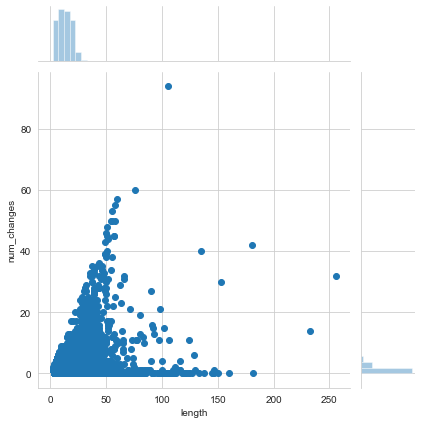

In [58]:
plt.figure(figsize=(15,5))
#sns.jointplot(x="length", y="num_changes", data=train_sentences_info, kind="kde")
sns.jointplot(x="length", y="num_changes", data=train_sentences_info)

For sentences that had more than 1 change, it appears as if yes, longer sentences do typically have more changes than shorter ones. Let's take a closer look.

<Figure size 1080x360 with 0 Axes>

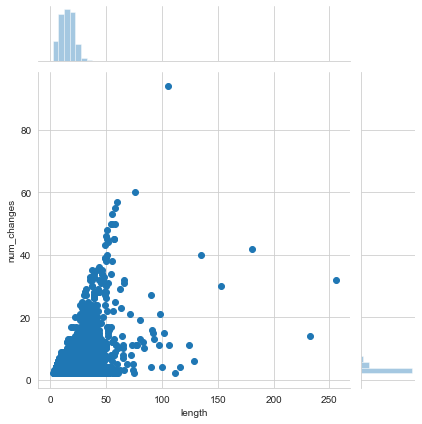

In [59]:
plt.figure(figsize=(15,5))
sns.jointplot(x="length", y="num_changes", data=train_sentences_info[train_sentences_info.num_changes > 1])

There appears to be a weak correlation between sentence length and number of changes.

The token id tells us the position of a token in the sentence. I would guess that there are positions in a specific kind of sentence (whatever that means... must be specified) whose tokens change more often. This would also relate to the language grammar structure. Which position in each sentence is changed most often?

Text(0, 0.5, 'Number of changes')

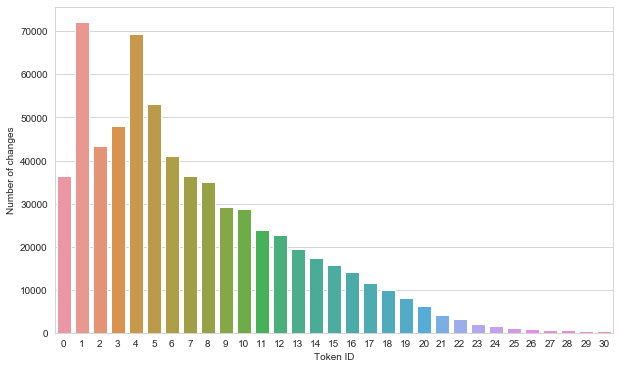

In [60]:
plt.figure(figsize=(10,6))
sns.countplot(x="token_id", data=train[(train.change==1) & (train.token_id <=30)])
plt.xlabel("Token ID")
plt.ylabel("Number of changes")

We see that sentences less or equal than 30 tokens (which corresponds to the major part of sentence length in this dataset) changed most in the first and forth position.

Given sentences less or equal than 30 tokens, which positions in these sentences changed most often?

In [61]:
collected = train[train.change==1][["sentence_id", "token_id"]]
collected["sentence_length"] = collected["sentence_id"].apply(lambda l: train_sentences_info.loc[l, "length"])
collected = collected[collected.sentence_length <= 30]
collected.head()

,sentence_id,token_id,sentence_length
10,1,0,8
11,1,1,8
51,3,7,20
80,5,0,12
95,6,3,14


In [62]:
changed_positions = collected.groupby("sentence_length")["token_id"].value_counts().unstack()
changed_positions.describe()

token_id,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
count,29.000000,29.000000,28.000000,27.000000,26.000000,25.000000,24.000000,23.000000,22.000000,21.000000,...,10.000000,9.000000,8.000000,7.000000,6.000000,5.00000,4.000000,3.000000,2.000000,1.0
mean,1247.724138,2479.586207,1537.178571,1767.407407,2655.153846,2116.760000,1689.625000,1565.173913,1573.500000,1376.476190,...,597.400000,427.222222,342.625000,252.857143,224.333333,175.80000,124.750000,127.000000,70.000000,2.0
std,1815.113867,1925.181467,1106.243529,1731.086325,5610.953086,2862.777109,1658.088785,1514.137668,1697.422914,1425.371833,...,848.214622,534.722306,356.349322,233.384824,206.640428,140.43041,102.801994,105.147515,90.509668,NaN
min,43.000000,4.000000,67.000000,74.000000,86.000000,70.000000,71.000000,92.000000,85.000000,79.000000,...,71.000000,52.000000,40.000000,35.000000,14.000000,12.00000,11.000000,7.000000,6.000000,2.0
25%,357.000000,845.000000,483.750000,456.500000,401.500000,333.000000,320.000000,298.500000,285.000000,228.000000,...,123.000000,103.000000,111.750000,89.500000,99.750000,105.00000,51.500000,89.000000,38.000000,2.0
50%,1026.000000,2988.000000,1621.500000,1622.000000,1707.500000,1671.000000,1566.000000,1462.000000,1408.500000,1275.000000,...,204.500000,174.000000,199.000000,196.000000,140.000000,116.00000,134.000000,171.000000,70.000000,2.0
75%,1410.000000,3347.000000,2113.500000,2163.500000,2486.000000,2300.000000,2156.500000,1974.500000,1852.500000,1667.000000,...,541.000000,361.000000,413.000000,360.500000,363.250000,315.00000,207.250000,187.000000,102.000000,2.0
max,10134.000000,9121.000000,4358.000000,7824.000000,29452.000000,12830.000000,6282.000000,6094.000000,6418.000000,5359.000000,...,2700.000000,1590.000000,1040.000000,639.000000,528.000000,331.00000,220.000000,203.000000,134.000000,2.0


In [63]:
changed_positions.fillna(0.0, inplace=True)
changed_positions = changed_positions.applymap(lambda l: np.log10(l+1))

In [64]:
mask = np.zeros_like(changed_positions.values)
mask[np.triu_indices_from(mask, k=2)] = True

Text(0.5, 1, 'Frequency of changed positions in sentences (log10-scale)')

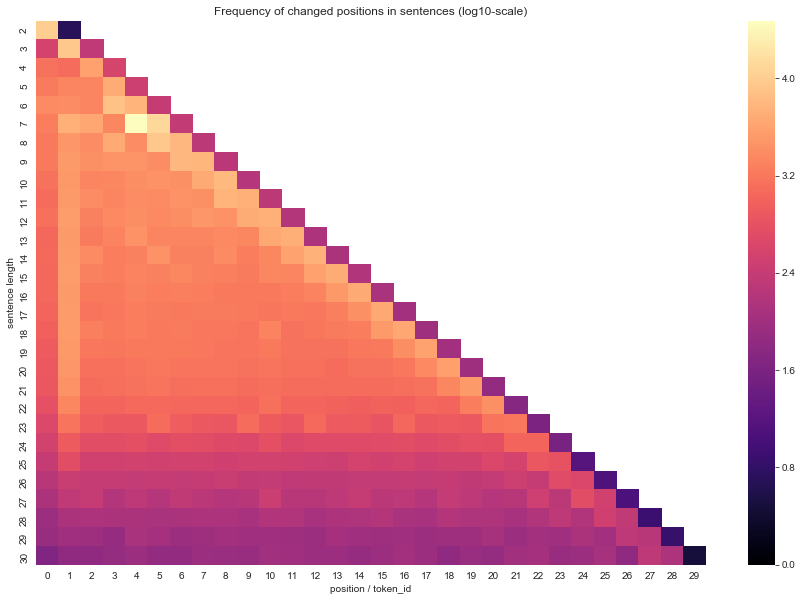

In [65]:
plt.figure(figsize=(15,10))
sns.heatmap(changed_positions, mask=mask, cmap="magma")
plt.xlabel("position / token_id")
plt.ylabel("sentence length")
plt.title("Frequency of changed positions in sentences (log10-scale)")

Interesting! We see a lot of sentences changed in the second position or at the second to last. The last is probably just a "." as it is the most common token but not the most changed one. Sentences that are 7 tokens long are somehow special: They occur very often (see distribution of sentence length in the train data) and they changed with very high frequency on their last positions. What do these look like?

In [66]:
train7_info = train_sentences_info[train_sentences_info.length==7]

What do the changed 7-sentences look like with a change at position 4?

In [67]:
train7_sentence_ids = train7_info[train7_info.num_changes > 0].index.values
train7 = train[train.sentence_id.isin(train7_sentence_ids)]

In [68]:
train7_pos4_examples = train7[(train7.token_id==4) & (train7.change==1)].iloc[0:10,:]
sentence_ids = train7_pos4_examples.sentence_id.values
for idx in sentence_ids:
    before_sentence = train7[train7.sentence_id==idx].before.values.tolist()
    after_sentence = train7[train7.sentence_id==idx].after.values.tolist()
    before_sentence = ' '.join(before_sentence)
    after_sentence = ' '.join(after_sentence)
    print("before:" + before_sentence + "\n" + "_____after:" + after_sentence)

before:" Manga Minis , 11/17/09 " .
_____after:" Manga Minis , november seventeenth o nine " .
before:Burton , D. ( August 1999 ) .
_____after:Burton , d ( august nineteen ninety nine ) .
before:Singapore Youth Olympic Games Organising Committee .
_____after:Singapore Youth Olympic Games organizing Committee .
before:The median age was 32 years .
_____after:The median age was thirty two years .
before:Visser , Jeanne ( 11 March 2008 ) .
_____after:Visser , Jeanne ( the eleventh of march two thousand eight ) .
before:Dugan , Tracy ( October 26, 2008 ) .
_____after:Dugan , Tracy ( october twenty sixth two thousand eight ) .
before:Glover , Eleanor ( Sep 7, 2009 ) .
_____after:Glover , Eleanor ( september seventh two thousand nine ) .
before:McCormack , Ben ( 3 July 2007 ) .
_____after:McCormack , Ben ( the third of july two thousand seven ) .
before:Mary Grive Art F 200 X .
_____after:Mary Grive Art F two o o X .
before:Ayers , Andrew ( 2004 ) .
_____after:Ayers , Andrew ( two thousand f

This concludes my initial EDA for this data set.